<a href="https://colab.research.google.com/github/arjunakula/Teaching1_Pytorch_LinearRegression/blob/master/Multi_Task_Learning_Example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://towardsdatascience.com/tuning-a-multi-task-fate-grand-order-trained-pytorch-network-152cfda2e086

In [0]:
from __future__ import print_function, division

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

from torch.utils.data import Dataset, DataLoader

from PIL import Image
from random import randrange

import torch.nn.functional as F
from sklearn.metrics import f1_score
plt.ion()

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [0]:
url = 'https://raw.githubusercontent.com/arjunakula/Teaching1_Pytorch_LinearRegression/master/fgo_multiclass_labels.csv'
dat = pd.read_csv(url)

X=dat['image_name']
y = dat[['white', 'red',
       'green', 'black', 'blue', 'purple', 'gold', 'silver', 'gender_Female',
       'gender_Male', 'region_Asia', 'region_Egypt', 'region_Europe',
       'region_Middle East', 'fighting_type_magic', 'fighting_type_melee',
       'fighting_type_ranged', 'alignment_CE', 'alignment_CG', 'alignment_CN',
       'alignment_LE', 'alignment_LG', 'alignment_LN', 'alignment_NE',
       'alignment_NG', 'alignment_TN']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [0]:
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

In [0]:
#train
colors = ['white', 'red',
       'green', 'black', 'blue', 'purple', 'gold', 'silver']
color_train = y_train[colors]
color_nodes = color_train.shape[1]
color_train = color_train.values.tolist()

gender = ['gender_Female',
       'gender_Male']
gender_train = y_train[gender]
gender_nodes = gender_train.shape[1]
gender_train = gender_train.values.tolist()

region = ['region_Asia', 'region_Egypt', 'region_Europe',
       'region_Middle East']
region_train = y_train[region]
region_nodes = region_train.shape[1]
region_train = region_train.values.tolist()

fighting_style = ['fighting_type_magic', 'fighting_type_melee',
       'fighting_type_ranged']
fighting_style_train = y_train[fighting_style]
fighting_nodes = fighting_style_train.shape[1]
fighting_style_train = fighting_style_train.values.tolist()

alignment = ['alignment_CE', 'alignment_CG', 'alignment_CN',
       'alignment_LE', 'alignment_LG', 'alignment_LN', 'alignment_NE',
       'alignment_NG', 'alignment_TN']
alignment_train = y_train[alignment]
alignment_nodes = alignment_train.shape[1]
alignment_train = alignment_train.values.tolist()


In [9]:
print(color_nodes,gender_nodes,region_nodes,fighting_nodes,alignment_nodes)

8 2 4 3 9


In [10]:
#test
colors = ['white', 'red',
       'green', 'black', 'blue', 'purple', 'gold', 'silver']
color_test = y_test[colors]
color_nodes = color_test.shape[1]
color_test = color_test.values.tolist()

gender = ['gender_Female',
       'gender_Male']
gender_test = y_test[gender]
gender_nodes = gender_test.shape[1]
gender_test = gender_test.values.tolist()

region = ['region_Asia', 'region_Egypt', 'region_Europe',
       'region_Middle East']
region_test = y_test[region]
region_nodes = region_test.shape[1]
region_test = region_test.values.tolist()

fighting_style = ['fighting_type_magic', 'fighting_type_melee',
       'fighting_type_ranged']
fighting_style_test = y_test[fighting_style]
fighting_nodes = fighting_style_test.shape[1]
fighting_style_test = fighting_style_test.values.tolist()

alignment = ['alignment_CE', 'alignment_CG', 'alignment_CN',
       'alignment_LE', 'alignment_LG', 'alignment_LN', 'alignment_NE',
       'alignment_NG', 'alignment_TN']
alignment_test = y_test[alignment]
alignment_nodes = alignment_test.shape[1]
alignment_test = alignment_test.values.tolist()

print(color_nodes,gender_nodes,region_nodes,fighting_nodes,alignment_nodes)

8 2 4 3 9


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/images/0144.jpg'


In [0]:
im1 = Image.open(path)

In [0]:
im1 = im1.convert('RGB')

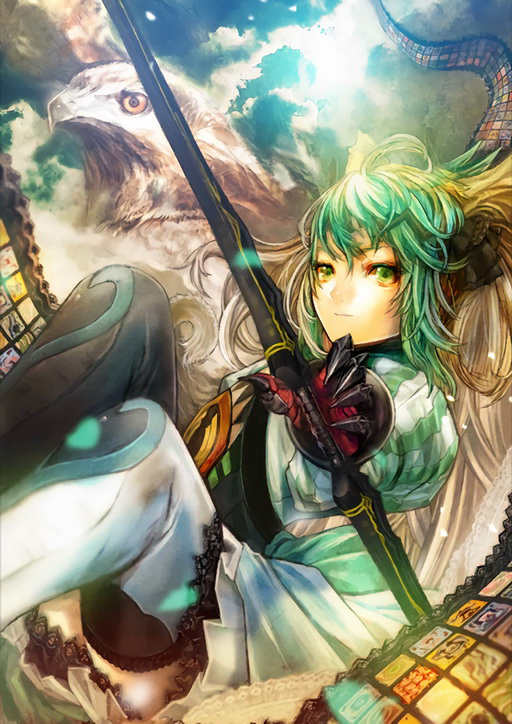

In [15]:
im1

In [0]:
# write custom dataset loader

class fgo_dataset(Dataset):
  def __init__(self, king_of_lists, transform=None):
    self.king_of_lists = king_of_lists
    self.transform = transform
    
  def __getitem__(self, index):
    img1 = Image.open('/content/drive/My Drive/images/'+self.king_of_lists[0][index])
    img1 = img1.convert('RGB')
    
    gender = self.king_of_lists[1][index]
    region = self.king_of_lists[2][index]
    fight = self.king_of_lists[3][index]
    alignment = self.king_of_lists[4][index]
    color = self.king_of_lists[5][index]
    
    if self.transform is not None:
      img1 = self.transform(img1)
      
    list_of_labels = [torch.from_numpy(np.array(gender)), 
                     torch.from_numpy(np.array(region)),
                     torch.from_numpy(np.array(fight)),
                     torch.from_numpy(np.array(alignment)),
                     torch.from_numpy(np.array(color))]
    
    return img1, list_of_labels[0], list_of_labels[1], list_of_labels[2], list_of_labels[3], list_of_labels[4]
  
  
  def __len__(self):
    return len(self.king_of_lists[0])

In [0]:
batch_size = 16
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_lists = [X_train, gender_train, region_train, fighting_style_train, alignment_train, color_train]
test_lists = [X_test, gender_test, region_test, fighting_style_test, alignment_test, color_test]

training_dataset = fgo_dataset(king_of_lists = train_lists,
                               transform = data_transforms['train'] )

test_dataset = fgo_dataset(king_of_lists = test_lists,
                           transform = data_transforms['val'] )

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}



In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
training_dataset[1]


(tensor([[[-0.6109, -0.7137, -0.8164,  ..., -1.8439, -1.8610, -1.8439],
          [-0.7479, -0.8678, -1.0048,  ..., -1.8268, -1.8268, -1.8097],
          [-1.2103, -1.3130, -1.4329,  ..., -1.8097, -1.7754, -1.6898],
          ...,
          [ 2.2318,  2.2318,  2.2147,  ...,  0.7077,  0.7933,  0.8104],
          [ 2.2318,  2.2318,  2.2147,  ...,  0.7762,  0.8104,  0.7933],
          [ 2.2318,  2.2147,  2.2147,  ...,  0.7933,  0.7762,  0.7591]],
 
         [[-1.4930, -1.5630, -1.6155,  ..., -1.7381, -1.7556, -1.7556],
          [-1.6155, -1.6506, -1.6856,  ..., -1.7206, -1.7381, -1.7206],
          [-1.7031, -1.7381, -1.7731,  ..., -1.7381, -1.7206, -1.6681],
          ...,
          [-2.0007, -1.9832, -2.0007,  ..., -1.8431, -1.8256, -1.8081],
          [-2.0007, -1.9832, -2.0007,  ..., -1.8256, -1.8256, -1.8081],
          [-2.0007, -2.0007, -2.0007,  ..., -1.8256, -1.8256, -1.8256]],
 
         [[ 0.0605, -0.1661, -0.3404,  ..., -0.3230, -0.3578, -0.3753],
          [-0.3055, -0.5670,